In [241]:
# Fraud Detection using statistical methods and machine learning algorithm

# importig necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [242]:
# Load the dataset
df = pd.read_csv(r"C:\Users\donad\OneDrive\Desktop\BSBI\Fundamental\Project\3\credit_card_transactions_with_fraud.csv")
df

,Transaction ID,Date,Time,Amount,Merchant,Card Number,Transaction Type,Is_Fraud
0,1,2023-11-24,1900-01-01 13:07:34,685.01,Walmart,3843821200548949,purchase,0
1,2,2023-02-27,1900-01-01 07:41:09,416.21,Best Buy,5383086218024020,transfer,0
2,3,2023-01-13,1900-01-01 08:52:09,840.05,Best Buy,3260571425540683,purchase,0
3,4,2023-05-21,1900-01-01 02:03:10,489.21,Target,8732700188790304,transfer,0
4,5,2023-05-06,1900-01-01 09:38:47,83.59,Starbucks,1429726801697379,transfer,0
...,...,...,...,...,...,...,...,...
995,996,2023-05-16,1900-01-01 19:03:55,738.80,Target,9273126227377999,purchase,0
996,997,2023-11-17,1900-01-01 11:00:31,95.90,Target,9436831649417841,refund,0
997,998,2023-10-29,1900-01-01 04:12:52,758.45,Walmart,7465289152251215,transfer,0
998,999,2023-12-05,1900-01-01 12:35:32,46.84,Starbucks,9242652051562987,purchase,0


In [243]:
df.isnull().sum()

Transaction ID       0
Date                 0
Time                 0
Amount              50
Merchant             0
Card Number          0
Transaction Type     0
Is_Fraud             0
dtype: int64

In [244]:
# Data Cleaning and Preprocessing
# Convert 'Date' to datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Extract time from 'Time' column
df['Time'] = pd.to_datetime(df['Time'], errors='coerce').dt.time

# Handle missing values
df['Amount'].fillna(df['Amount'].mean(), inplace=True)

In [245]:
# Exploratory Data Analysis (EDA)
# Summary statistics
print(df.describe())


       Transaction ID       Amount   Card Number    Is_Fraud
count     1000.000000  1000.000000  1.000000e+03  1000.00000
mean       500.500000   522.010847  5.499337e+15     0.02000
std        288.819436   360.888854  2.569964e+15     0.14007
min          1.000000     1.680000  1.001763e+15     0.00000
25%        250.750000   258.322500  3.252104e+15     0.00000
50%        500.500000   522.010847  5.601401e+15     0.00000
75%        750.250000   752.532500  7.701395e+15     0.00000
max       1000.000000  3577.212094  9.983486e+15     1.00000


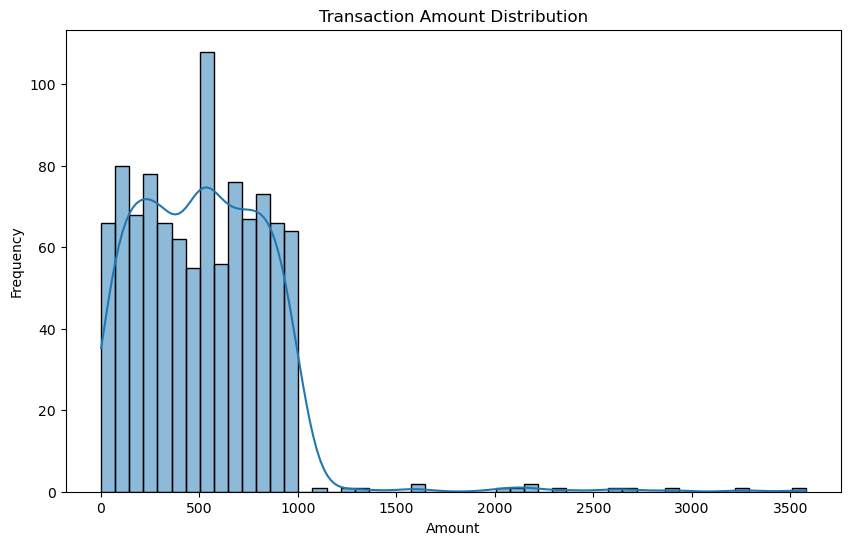

In [246]:
# histogram Plotting of transacttion amount
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


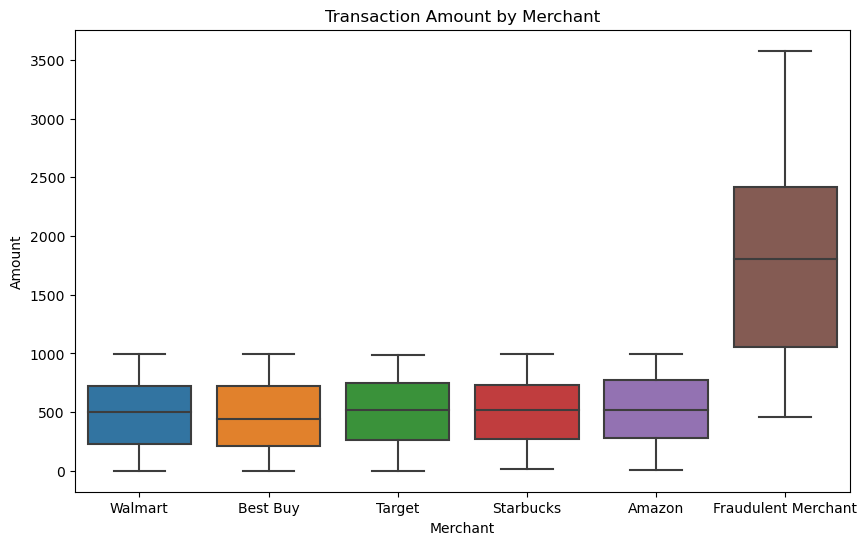

In [247]:
# boxplot visualization of different merchants
plt.figure(figsize=(10, 6))
sns.boxplot(x='Merchant', y='Amount', data=df)
plt.title('Transaction Amount by Merchant')
plt.xlabel('Merchant')
plt.ylabel('Amount')
plt.show()


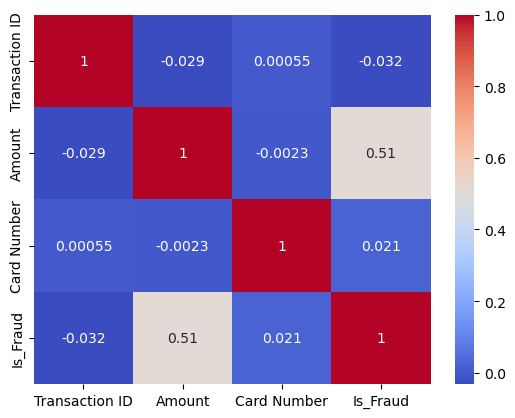

In [248]:
# displaying correlation matrix
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [249]:
# Representing Data as Vectors and Matrices
# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Merchant', 'Transaction Type'])

In [250]:
# Normalize 'Amount'
scaler = StandardScaler()
df_encoded['Amount'] = scaler.fit_transform(df_encoded[['Amount']])

In [251]:
# Convert DataFrame to matrix
transaction_matrix = df_encoded.to_numpy()

In [252]:
# Apply Statistical Methods for Anomaly Detection
# Z-score method
df_encoded['Z-Score'] = zscore(df_encoded['Amount'])
threshold = 3
df_encoded['Is Anomaly (Z-Score)'] = (np.abs(df_encoded['Z-Score']) > threshold).astype(int)


In [253]:
# Isolation Forest
iso_forest = IsolationForest(contamination=0.02)
df_encoded['Is Anomaly (Isolation Forest)'] = iso_forest.fit_predict(df_encoded.drop(columns=['Transaction ID', 'Date', 'Time', 'Z-Score']))
df_encoded['Is Anomaly (Isolation Forest)'] = df_encoded['Is Anomaly (Isolation Forest)'].apply(lambda x: 1 if x == -1 else 0)

In [254]:
# Combine anomaly detection results
df['Is Anomaly'] = df_encoded[['Is Anomaly (Z-Score)', 'Is Anomaly (Isolation Forest)']].max(axis=1)

In [255]:
# Generate Classification Report
report = classification_report(df['Is_Fraud'], df['Is Anomaly'], target_names=['Non-Fraud', 'Fraud'])
print(report)

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00       980
       Fraud       1.00      1.00      1.00        20

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



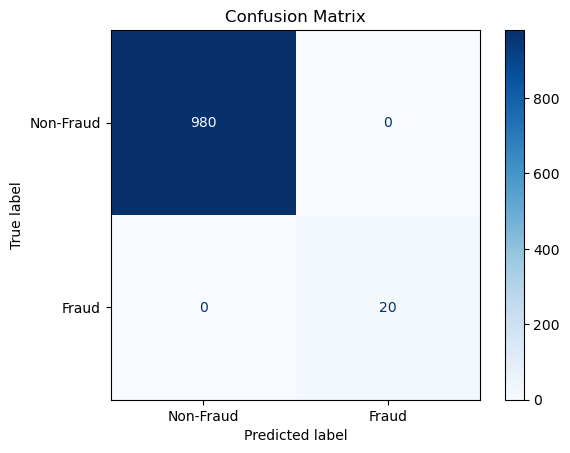

In [256]:
# Calculate Confusion Matrix
cm = confusion_matrix(df['Is_Fraud'], df['Is Anomaly'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [257]:
# Separate data for logistic regression
X = df_encoded.drop(columns=['Transaction ID', 'Date', 'Time', 'Card Number','Is_Fraud', 'Z-Score','Is Anomaly (Z-Score)','Is Anomaly (Isolation Forest)'])
y = df_encoded['Is_Fraud']

In [258]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [259]:
# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [260]:
# Predict on the test set
y_pred = model.predict(X_test)

In [261]:
# Generate Classification Report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       1.00      1.00      1.00         5

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



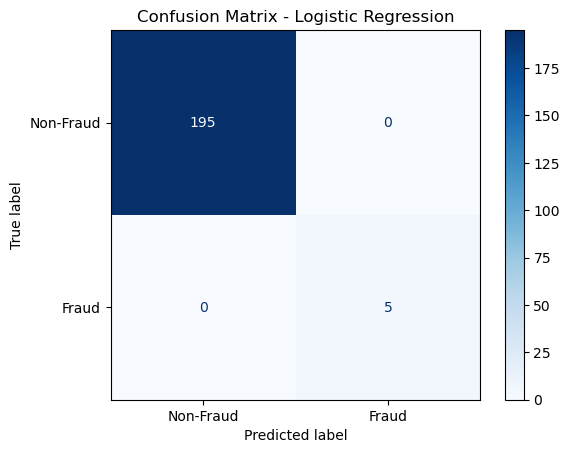

In [262]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()